In [1]:
import string
import random
from IPython.display import display, clear_output
from PIL import Image, ImageOps, ImageDraw, ImageFont, ImageChops
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets
from ipywidgets import interactive, HBox, VBox
from img_processing import preprocess_img, DITHER_MODES
from ascii_art_non_mono_utils import *
from ascii_art_non_mono_algorithms import *
from skimage import metrics

In [2]:
font_path = "fonts/OpenSans-Regular.ttf"
size = 18
font = ImageFont.truetype(font_path, size)

In [3]:
orig_img = Image.open("imgs/irad_grad.bmp").convert("L")
#orig_img = ImageOps.invert(orig_img)

print(orig_img.size)

(512, 512)


In [4]:
def i_preprocess_img(scale_factor, contrast, brightness, quantize_colors, eq, dither):
    proc_img = preprocess_img(orig_img, 0.3, 1.1, 0.5, 0.2, 128, DITHER_MODES.NONE)
    plt.imshow(proc_img, cmap='gray', vmin=0, vmax=255, interpolation='none')

    plt.figure(figsize=(9, 3))
    plt.xticks([x for x in range(0, len(proc_img.histogram()), 25)])
    plt.bar([x for x in range(0, len(proc_img.histogram()))], proc_img.histogram())
    plt.grid()
    plt.show()

    return proc_img

interactive_preprocess = interactive(i_preprocess_img,
            scale_factor=(0.01, 1, 0.01),
            contrast=(0, 2, 0.01),
            brightness=(0, 2, 0.01),
            eq=(0, 1, 0.01),
            quantize_colors=(1, 256, 1),
            dither=DITHER_MODES)

controls = VBox(interactive_preprocess.children[:-1])
#display(HBox((controls, interactive_preprocess.children[-1])))

In [5]:
proc_img = interactive_preprocess.result

In [6]:
palette = list(filter(lambda a: a.isprintable(), string.printable))
print(len(palette))
print(palette)

95
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' ']


In [7]:
all_lines = split_lines(proc_img, palette, font)
print(len(all_lines))
lines = [all_lines[len(all_lines) // 4], all_lines[len(all_lines) // 2], all_lines[-len(all_lines) // 4]]
for l in lines:
    display(l)

6


In [8]:
# for l in lines:
#     text_arr = generate_greedy_line(l, palette, font)
#     print(evaluate_text_arr(text_arr, l, font))
#     bg_img, bg_draw = new_img_draw(l.size)
#     draw_text_arr(bg_draw, text_arr, font)
#     display(ImageChops.difference(bg_img, l))

In [9]:
# for l in lines:
#     lhs = lazy_generate_harmony_line(l, palette, font, 10, 0.8, 0.3, len(palette)//2)
#     for i in range(101):
#         p_ids_arr, fit = next(lhs)
#         if i % 100 == 0:
#             print(fit)
#     bg_img, bg_draw = new_img_draw(l.size)
#     draw_text_arr(bg_draw, palette_id_arr_to_text_arr(p_ids_arr, palette), font)
#     display(ImageChops.difference(bg_img, l))

              ...             
      II@@@@JJJI     
   II@@@@@@JJI   
   I@@@@@@$JII  
     II@@@@$JJII    
          IIIIIIIIIII         

0.738859345391049


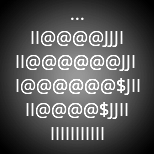

In [10]:
text = greedy_algorithm(proc_img, palette, font)
print(''.join(text))

bg_img, draw = new_img_draw(proc_img.size)
draw_text_arr(draw, text, font)
print(evaluate_text_arr(text, proc_img, font))
ImageChops.add(proc_img, bg_img)

4 0.7270265130845727


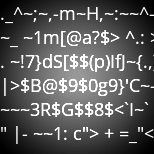

._^~;~,-m~H,~:~~^-
~_ ~1m[@a?$> ^.: >
. ~!7}dS[$$(p)IfJ~{.,
|>$B@$9$0g9}'C~
~~~3R$G$$8$<`I~`
" |- ~~1: c"> + =_"<

0.7271187813968563


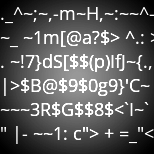

In [11]:
lhs = pool_harmony_search(proc_img, palette, font, 1000, 5, 0.8, 0.3, len(palette)//4)

for i in range(5):
    text = next(lhs)
    clear_output()
    print(i, evaluate_text_arr(text, proc_img, font))
    bg_img, draw = new_img_draw(proc_img.size)
    draw_text_arr(draw, text, font)
    display(ImageChops.add(proc_img, bg_img))

for i in range(len(text)):
    text[i] = text[i][:find_end_of_line(text[i], proc_img, font)] + '\n'
print(''.join(text))

bg_img, draw = new_img_draw(proc_img.size)
draw_text_arr(draw, text, font)
print(evaluate_text_arr(text, proc_img, font))
ImageChops.add(proc_img, bg_img)